In [1]:
'''
Date: 18/Jan/2022
Auther: Yike Xie
Content: Figure 1 in dengue paper
'''

'\nDate: 18/Jan/2022\nAuther: Yike Xie\nContent: Figure 1 in dengue paper\n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [4]:
def pre_processing_1(adata, cell_type):
    temp = adata[adata.obs.cell_type_new == cell_type].copy()
    sc.pp.filter_genes(temp, min_cells=3)
    
    virus_nor(temp)
    
    ind = temp.obs.DENV_reads_nor.sort_values(ascending = False).head(100).index

    temp.obs['bystanders'] = 'low'
    temp.obs.loc[ind, 'bystanders'] = 'high'
    temp.obs.loc[temp.obs.DENV_reads_nor==0, 'bystanders'] = 'zero'
    
    return(temp)

def pre_processing_2(adata):
    temp = adata.copy()
    sc.pp.filter_genes(temp, min_cells=3)
    
    virus_nor(temp)
    
    temp.obs['bystanders'] = 'high'
    temp.obs.loc[temp.obs.DENV_reads_nor==0, 'bystanders'] = 'zero'
    
    return(temp)

def violin_virus(adata, color, path, name, filetype=False):
    rcParams['figure.figsize']=(6,6)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    adata.obs['bystanders_2'] = 'bystanders'
    adata.obs.loc[adata.obs.bystanders != 'zero', 'bystanders_2'] = 'VHCs'
    
    fig, ax = plt.subplots()
    sc.pl.violin(adata, ['DENV_reads_nor'], groupby = 'bystanders_2', palette = ['#ED3E3E', 'grey'], ax = ax, 
                 xlabel = 'B cells', ylabel = 'DENV reads (log2(cpm))', show = False)
    
    ax.set_xticklabels(['VHCs', 'Bystanders'])
    ax.set_title('VHCs vs Bystanders')
    
    if filetype is not False:
        filename = name + '.' + filetype
        fig.savefig(os.path.join(path, filename),
                   bbox_inches='tight')
    
def get_df(adata, group):
    dic = {}
    colnames = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']
    for x in colnames:
        dic[x] = adata.uns['wilcoxon'][x][group]
    df = pd.DataFrame(dic)
    df.set_index('names', inplace = True)
    return(df)
    
def utest(adata):
    temp = adata[adata.obs.bystanders != 'low'].copy()
    sc.tl.rank_genes_groups(temp, 'bystanders', method='wilcoxon', 
                            key_added = "wilcoxon", corr_method = 'bonferroni')
    
    df_utest = get_df(temp, 'high')
    df_utest_2 = df_utest.loc[(df_utest.pvals_adj<0.05)&(df_utest.logfoldchanges.abs()>1)]
    return(df_utest_2)

from random import sample

def sampling(adata):
    ind_bystander = list(adata[adata.obs.loc[:,'bystanders'] == 'zero',].obs.index)
    length_vhc = len(adata[adata.obs.loc[:,'bystanders'] == 'high',].obs.index)
    samplelist = sample(ind_bystander, length_vhc)
    
    return(samplelist)

def dge_KS(adata, samplelist, p):
    adata_1 = adata[np.in1d(adata.obs.index, samplelist),:]
    adata_2 = adata[adata.obs.loc[:,'bystanders'] == 'high',:]
    results = anndataks.compare(adata_1, adata_2, log1p=2)
    results_sort = results.sort_values(by = 'statistic', ascending=False)
    results_sort['-log10p'] = pd.Series(-np.log10(results_sort['pvalue']))
    results_sort_2 = results_sort[(results_sort['-log10p'] > p) & (results_sort['log2_fold_change'].abs() > 1)].copy()
    
    return(results_sort, results_sort_2)

def bootstrap(adata, n, p):
    dic_1 = {}
    dic_2 = {}
    for x in np.arange(n):
        sample_list = sampling(adata)
        result_temp_1,  result_temp_2 = dge_KS(adata, sample_list, p)
        dic_1[x] = result_temp_1
        dic_2[x] = result_temp_2
        
        gene = []
    for key in dic_2.keys():
        gene = gene + list(dic_2[key].index)
    a = pd.Series(gene).value_counts().to_frame()
    return(dic_1, dic_2, a)

def dge_KS_2(adata, samplelist, p):
    adata_1 = adata[np.in1d(adata.obs.index, samplelist),:]
    adata_2 = adata[adata.obs.loc[:,'bystanders'] == 'high',:]
    results = anndataks.compare(adata_1, adata_2, log1p=2)
    results_sort = results.sort_values(by = 'statistic', ascending=False)
    results_sort['-log10p'] = pd.Series(-np.log10(results_sort['pvalue']))
    results_sort_2 = results_sort[(results_sort['log2_fold_change'].abs() > 1)].copy()
    
    return(results_sort, results_sort_2)

def bootstrap_2(adata, n, p):
    dic_1 = {}
    dic_2 = {}
    for x in np.arange(n):
        sample_list = sampling(adata)
        result_temp_1,  result_temp_2 = dge_KS_2(adata, sample_list, p)
        dic_1[x] = result_temp_1
        dic_2[x] = result_temp_2
        
    gene = []
    for key in dic_2.keys():
        gene = gene + list(dic_2[key].index)
    a = pd.Series(gene).value_counts().to_frame()
    
    return(dic_1, dic_2, a)
        
def dicmerge_p(dic, gene_list):
    df_temp = pd.DataFrame(columns = np.arange(100), index = gene_list)
    for key in dic.keys():
        df_temp.loc[:,key] = dic[key].loc[:,'-log10p']
    df_temp['median'] = df_temp.median(axis = 1)
    return(df_temp)       

def dicmerge(dic, gene_list):
    df_temp = pd.DataFrame(columns = np.arange(100), index = gene_list)
    for key in dic.keys():
        df_temp.loc[:,key] = dic[key].loc[gene_list].log2_fold_change
    df_temp['median'] = df_temp.median(axis = 1)
    return(df_temp)

def pairwise_barplot(df, path, name, filetype=False, figure_size = (14, 12), xlim_down = -4.5, xlim_up = 4.5):
    rcParams['figure.figsize']=figure_size
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    df['VHC vs Bystander'] = 'no difference'
    df.loc[df['median'] < -1, 'VHC vs Bystander'] = 'downregulate'
    df.loc[df['median'] > 1, 'VHC vs Bystander'] = 'upregulate'

    data = df.iloc[:,:-1].copy()
    data['gene'] = data.index
    data['VHC vs Bystander'] = df.loc[:,'VHC vs Bystander'].copy()

    data_2 = pd.melt(data, id_vars = ['gene', 'VHC vs Bystander'])
    
    fig, ax = plt.subplots()
    
    cmap = mpl.cm.get_cmap('coolwarm')
    norm = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
    palette = [cmap(norm(x)) for x in np.clip(data.median(axis=1), -2.5, 2.5)]
    
    ax = sns.boxplot(data = data_2, x = 'value', y = 'gene', orient = 'h',
                    palette = palette, dodge = False)

    ax.axvline(x = 0, ls = '--', lw = 2, c = 'black')
    ax.axvline(x = 1, ls = '--', lw = 2, c = 'black')
    ax.axvline(x = -1, ls = '--', lw = 2, c = 'black')

    ax.set_xlabel('diff log2(cpm)')
    ax.set_ylabel(None)
    ax.set_title(name)
    ax.set_xlim(xlim_down, xlim_up)
    
    ##############################################
    ax_cb = fig.add_axes([0.25, 0, 0.5, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.set_ticklabels(['-2', '-1', '0', '1', '2'])
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('Median of diff log2(cpm)', fontsize=15)
    
    if filetype is not False:
        filename = name + '.' + filetype
        fig.savefig(os.path.join(path, filename),
                   bbox_inches='tight')
    
def find_overlap(df_list, cutoff):
    overlap = []
    n = 0
    for df in df_list:
        if n == 0:
            overlap = list(df.loc[df[0] >=cutoff].index)
        else:
            overlap = [x for x in overlap if x in df.loc[df[0] >=cutoff].index]
        n = n + 1
        print(len(overlap))
    return(overlap)

def bar_plot_other_celltype(dic_list, genelist):    
    new_list = []
    for dic in dic_list:      
        df_temp = dicmerge(dic, genelist)
#         df_temp = df_temp.sort_values(by = 'median', ascending = False)
        new_list.append(df_temp)
    
    return(new_list)    

def barplot_multiple(df_list, n_cutoff_list, path, color, filetype, name_list, figure_size = (14, 12)):
    rcParams['figure.figsize']=figure_size
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    fig_ind=np.arange(151, 157) #index of the figure, the add_subplot has to be 3 digit
    fig = plt.figure()
    fig.subplots_adjust(hspace=1.5, wspace=0.05)
    
    ind = 0
    for df in df_list:
        genes_survival = list(n_cutoff_list[ind].loc[n_cutoff_list[ind][0]>=70].index)
        df['VHC vs Bystander'] = 'no difference'
        
        ind_down = [x for x in df.loc[df['median'] < -1].index if x in genes_survival]
        ind_up = [x for x in df.loc[df['median'] > 1].index if x in genes_survival]
        
        df.loc[ind_down, 'VHC vs Bystander'] = 'downregulate'
        df.loc[ind_up, 'VHC vs Bystander'] = 'upregulate'
        
        data = df.iloc[:,:-1].copy()
        data['gene'] = data.index
        data['VHC vs Bystander'] = df.loc[:,'VHC vs Bystander'].copy()
        
        data_2 = pd.melt(data, id_vars = ['gene', 'VHC vs Bystander'])
        
        
        ax_temp = fig.add_subplot(fig_ind[ind])
        sb.boxplot(data = data_2, x = 'value', y = 'gene', orient = 'h', hue = 'VHC vs Bystander',
                   hue_order = ['upregulate', 'no difference', 'downregulate'],
                   palette = color, dodge = False, ax = ax_temp)
        
        ax_temp.set_xlabel('diff_log2(cpm)')
        ax_temp.set_ylabel('')
        ax_temp.set_title(name_list[ind])
        ax_temp.set_xlim(-4.5,4)
        
        ax_temp.axvline(x = 0, ls = '--', lw = 2, c = 'black')
        ax_temp.axvline(x = 1, ls = '--', lw = 2, c = 'black')
        ax_temp.axvline(x = -1, ls = '--', lw = 2, c = 'black')
        
        if ind != 0:
            ax_temp.get_legend().remove()
            ax_temp.tick_params(axis='y', which='both', labelleft=False)
        else:
            ax_temp.legend(bbox_to_anchor=[0, 1])
            
        ind = ind + 1
    
    filename = 'mutiple_cell_type_VHC.' + filetype
    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')

def heatmap_virus(df, path, filetype=False):
    rcParams['figure.figsize']=(7, 14)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300

    fig, ax = plt.subplots()
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    ax = sns.heatmap(df, cmap=cmap, center=0, yticklabels=True,
                     cbar_kws={'label': 'Median of diff log2(cpm)', 'shrink': .3})
    if filetype is not False:
        plt.savefig(os.path.join(path, 'heatmap' + filetype),bbox_inches='tight')

In [5]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_20211001.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

#select high viral load 3 patients
ind = np.in1d(adata_kid.obs.ID, ['5_089_01', '6_025_01', '6_020_01'])
adata_kid_DWS = adata_kid[ind]

In [6]:
#subsetting to kids B cells and preprocessing
adata_kid_DWS_B = pre_processing_1(adata_kid_DWS, 'B_cells')

/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:233: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['DENV_reads_cpm'] = (temp.obs['DENV_reads'] / temp.obs['n_counts']) * 1e6


In [9]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].cat.categories.tolist()
cell_subtypes = adata_kid.obs['cell_subtype_new'].cat.categories.tolist()

In [10]:
# load palettes
ct_palette = load_ct_palette()
cst_palette = load_cst_palette()

# load save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_2/'
save_tabels = '/home/yike/phd/dengue/docs/paper_draft/tabels/'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


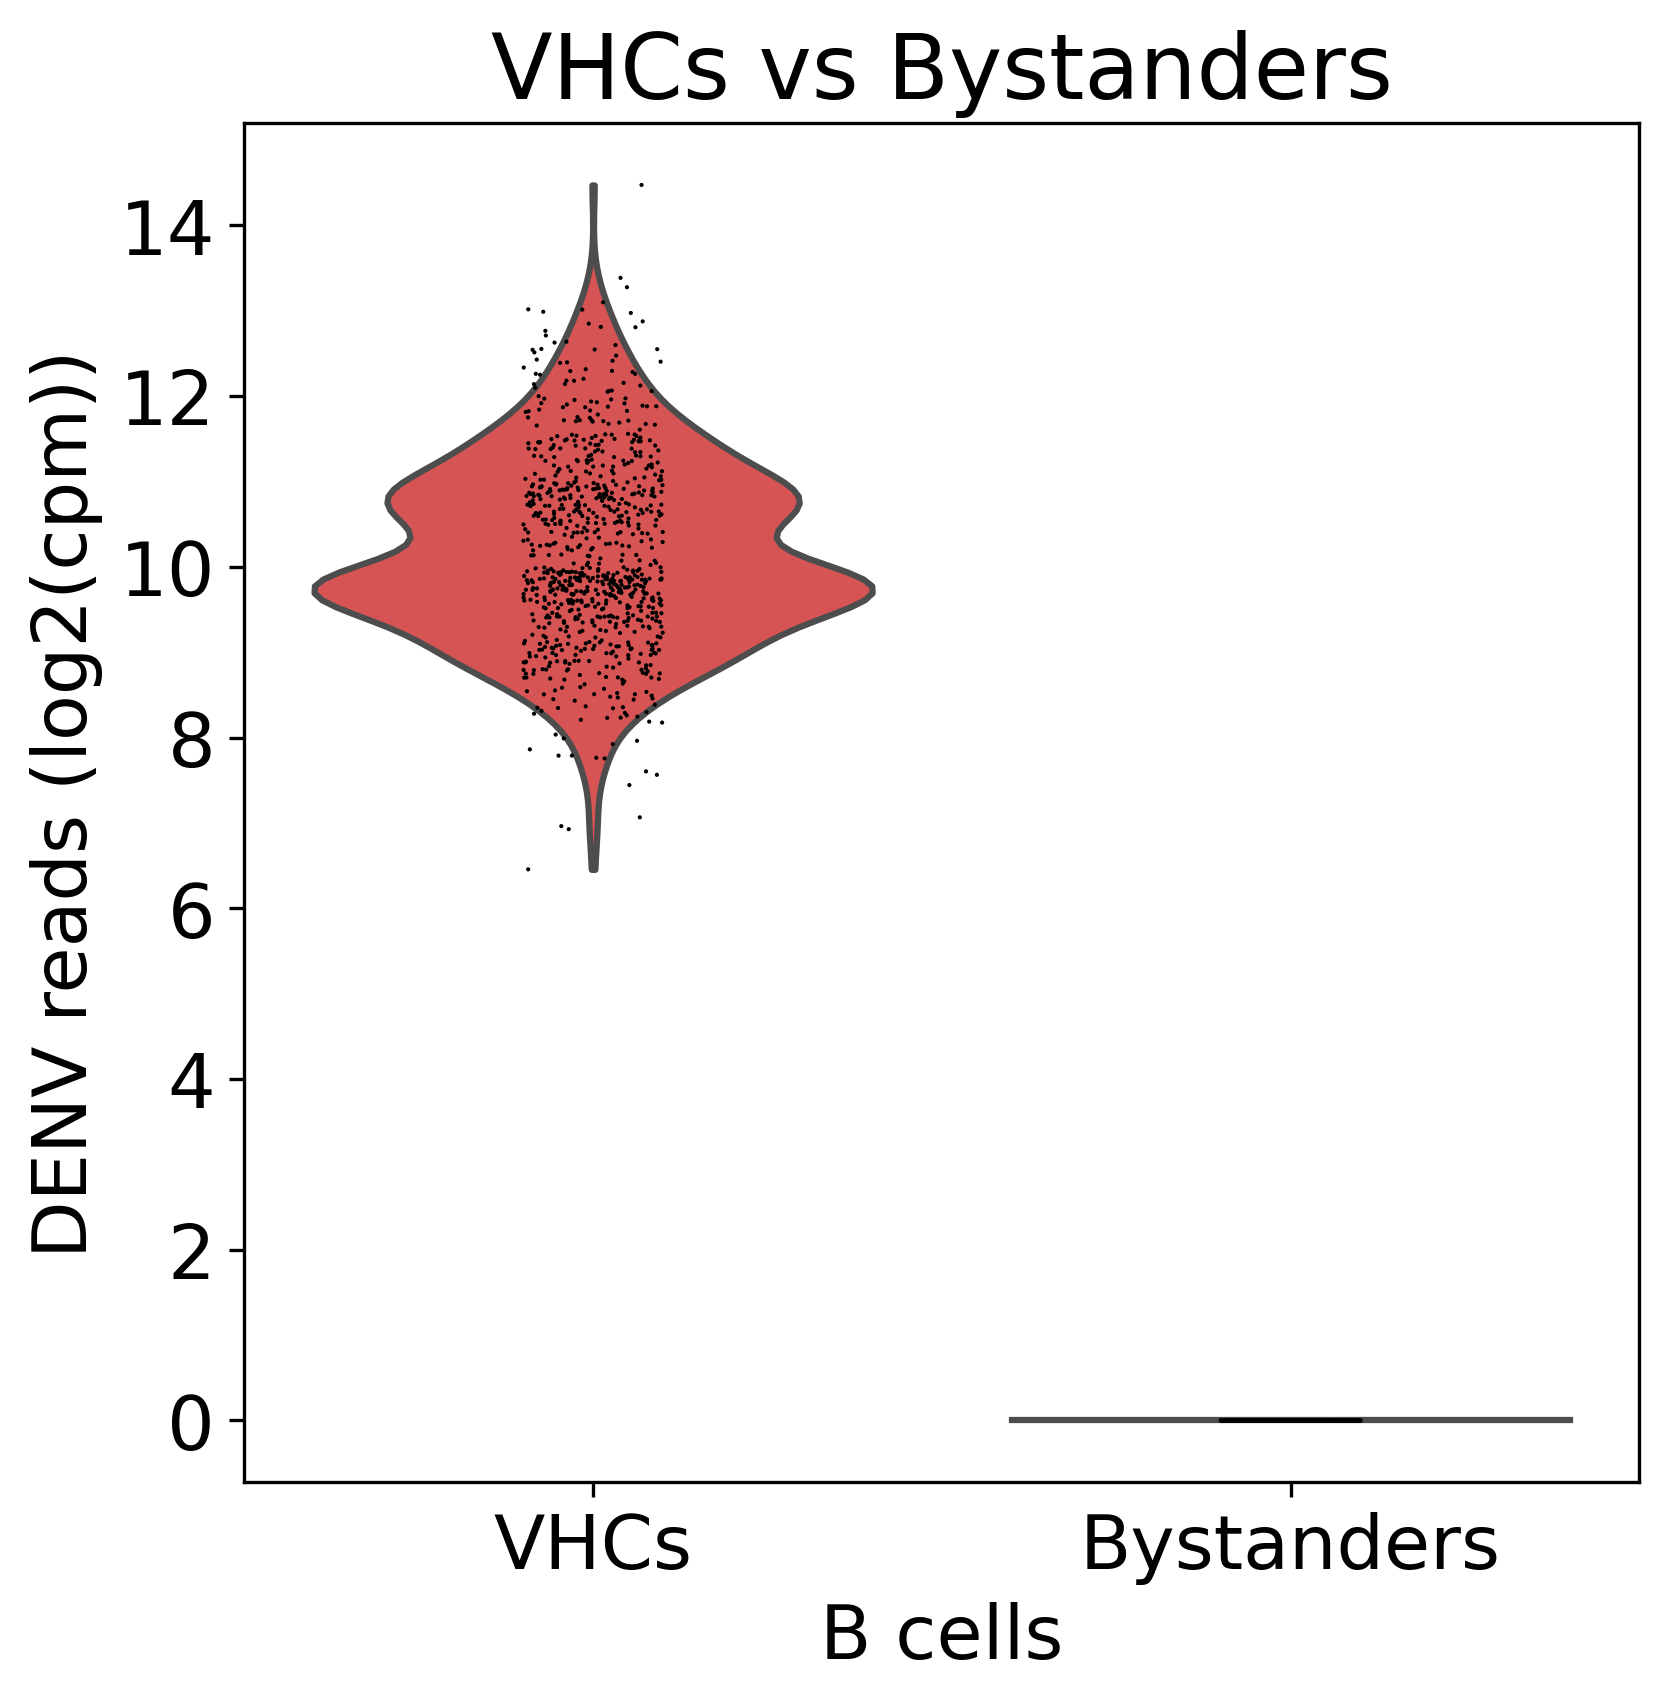

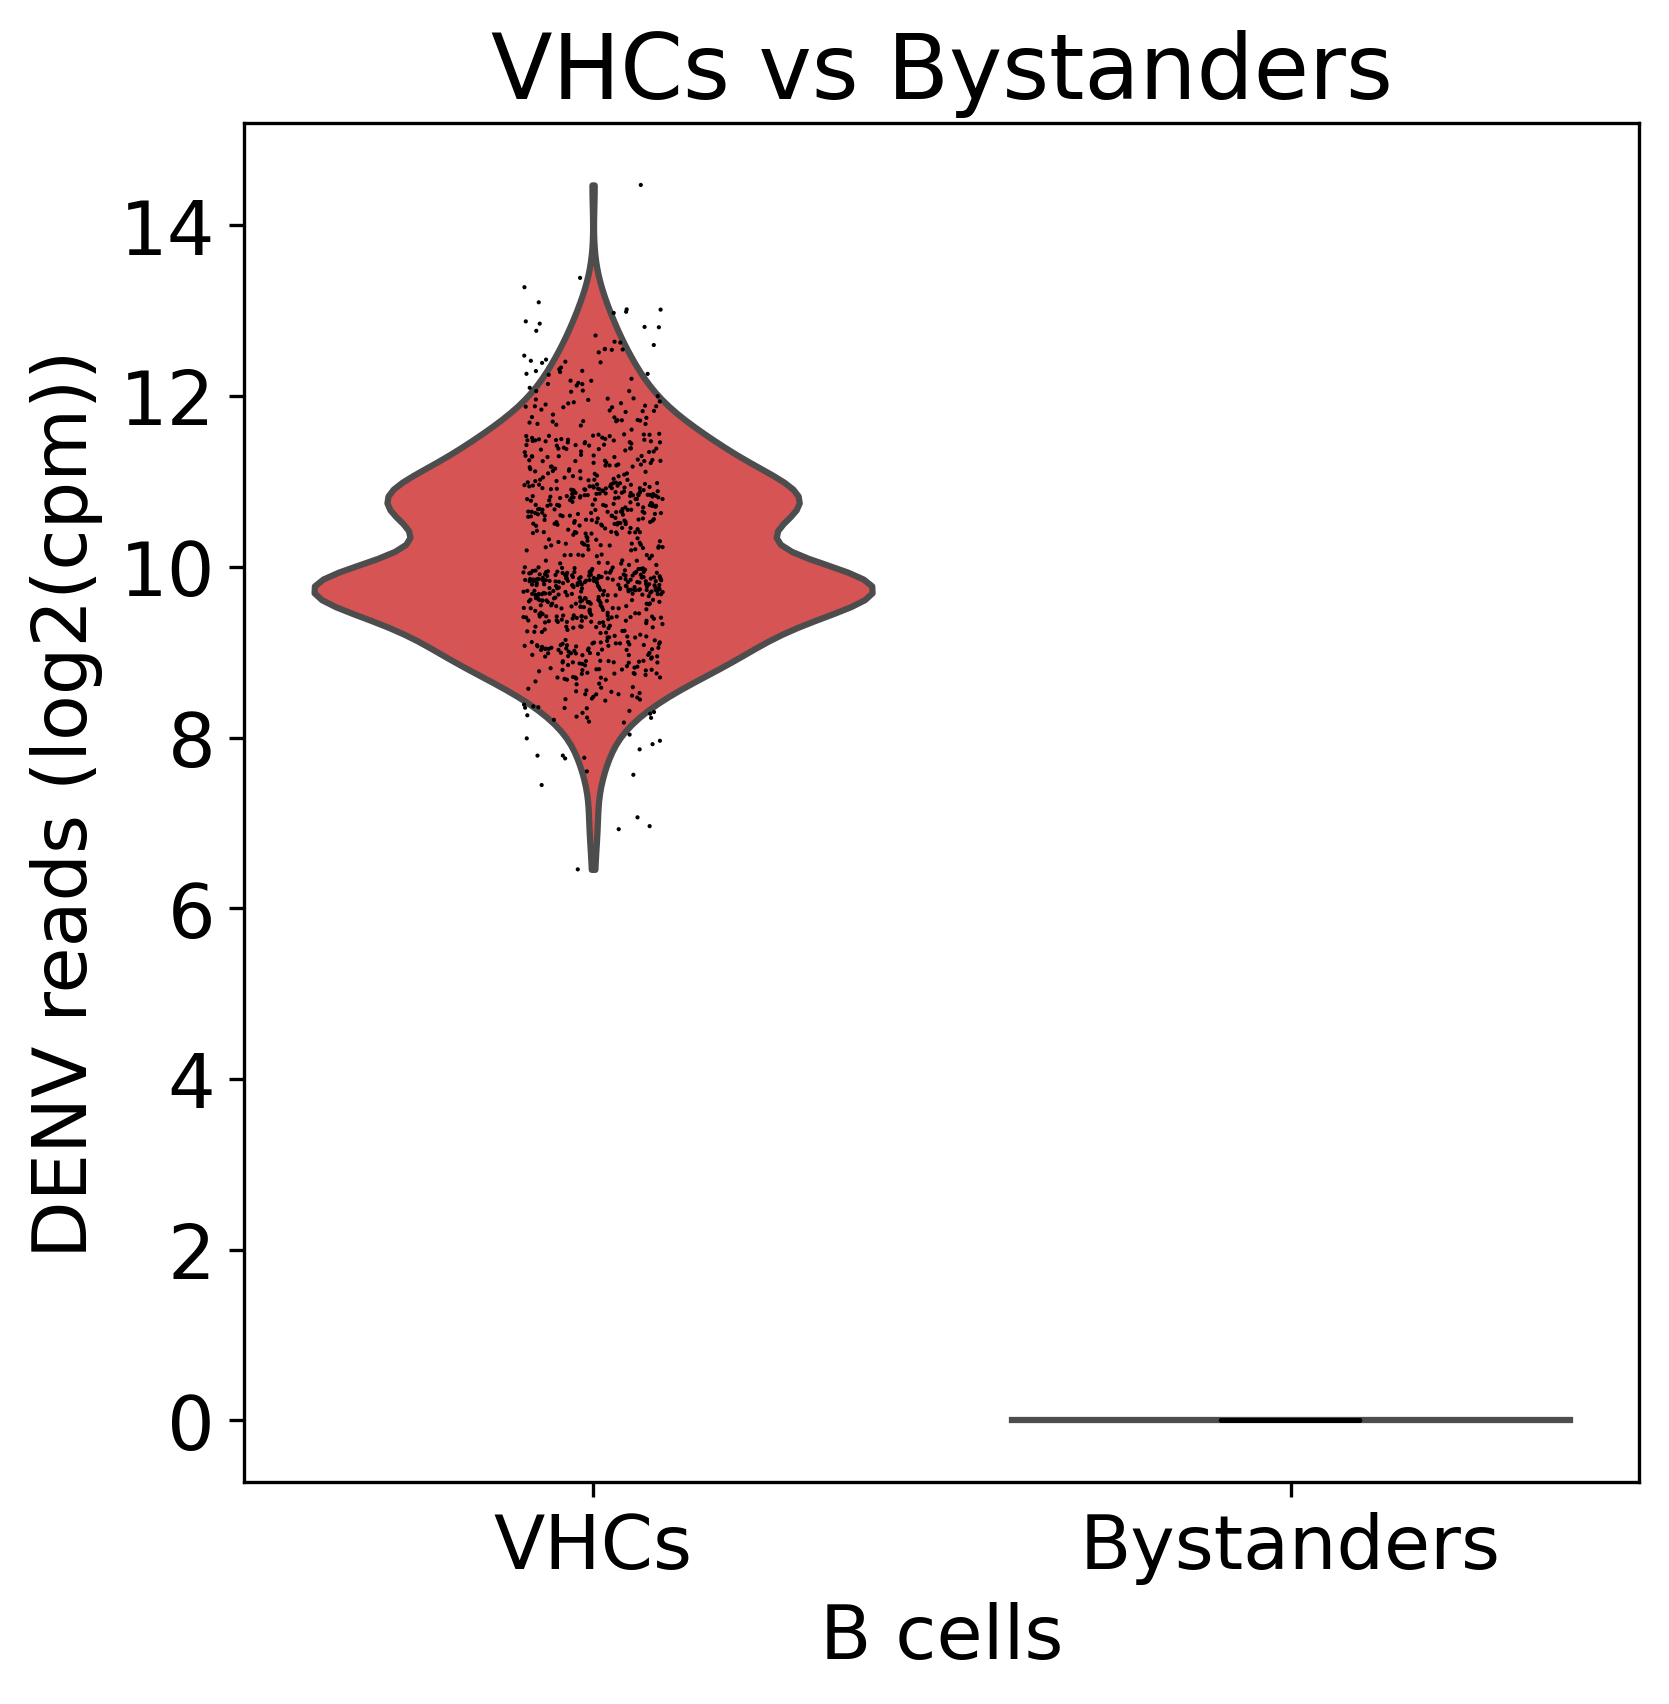

In [9]:
# Original Figure 2A
temp = adata_kid_DWS_B.copy()

violin_virus(temp, ['#ED3E3E', 'grey'], save_figures, name = 'VHC_violin_B', filetype='pdf')
violin_virus(temp, ['#ED3E3E', 'grey'], save_figures, name = 'VHC_violin_B', filetype='png')

In [20]:
#other cell types VHC dge, Figure 2D

common = ['MT-CO3', 'MT-ND4', 'MT-ND4L'] #,'MT-ND2', 'MT-ND5', 'MT-ND6'
b = ['CD69', 
     'CXCR4', 'FCER2', 'TCL1A', #'CCR7', 'IGHM', 'MS4A1', 
     'FCRLA','FCRL3', 'FCRL5', 'SYK', 'HCK', 'FGR',  
     'TXNIP', 'LTB', 'CIB1', 'TNFRSF1B',
    'MX1', 'IFI6', 'IFI30', 'LY6E', 'HLA-DRB5', 'HLA-DPA1']
m = ['LSM7', 'TCEA1', 'HNRNPM']
n = ['WIPF1', 'RABAC1', 'SEPT2']

genelist_heatmap = common + b + m + n

temp = adata_kid_DWS

#B
adata_temp = temp[temp.obs.cell_type_new == 'B_cells'].copy()
adata_temp = pre_processing_2(adata_temp)
adata_temp = adata_temp[:, genelist]
dic_b_1, dic_b_2, df_b = bootstrap_2(adata_temp, 100, 2)

#monocytes
adata_temp = temp[temp.obs.cell_type_new == 'Monocytes'].copy()
adata_temp = pre_processing_2(adata_temp)
adata_temp = adata_temp[:, genelist]
dic_m_1, dic_m_2, df_m = bootstrap_2(adata_temp, 100, 2)

#NK
adata_temp = temp[(temp.obs.cell_subtype_new == 'XCL_low NK cells') | 
                     (temp.obs.cell_subtype_new == 'XCL_high NK cells')].copy()
adata_temp = pre_processing_2(adata_temp)
adata_temp = adata_temp[:, genelist]
dic_n_1, dic_n_2, df_n = bootstrap_2(adata_temp, 100, 2)

/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:233: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['DENV_reads_cpm'] = (temp.obs['DENV_reads'] / temp.obs['n_counts']) * 1e6
/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:233: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['DENV_reads_cpm'] = (temp.obs['DENV_reads'] / temp.obs['n_counts']) * 1e6
/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:233: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['DENV_reads_cpm'] = (temp.obs['DENV_reads'] / temp.obs['n_counts']) * 1e6


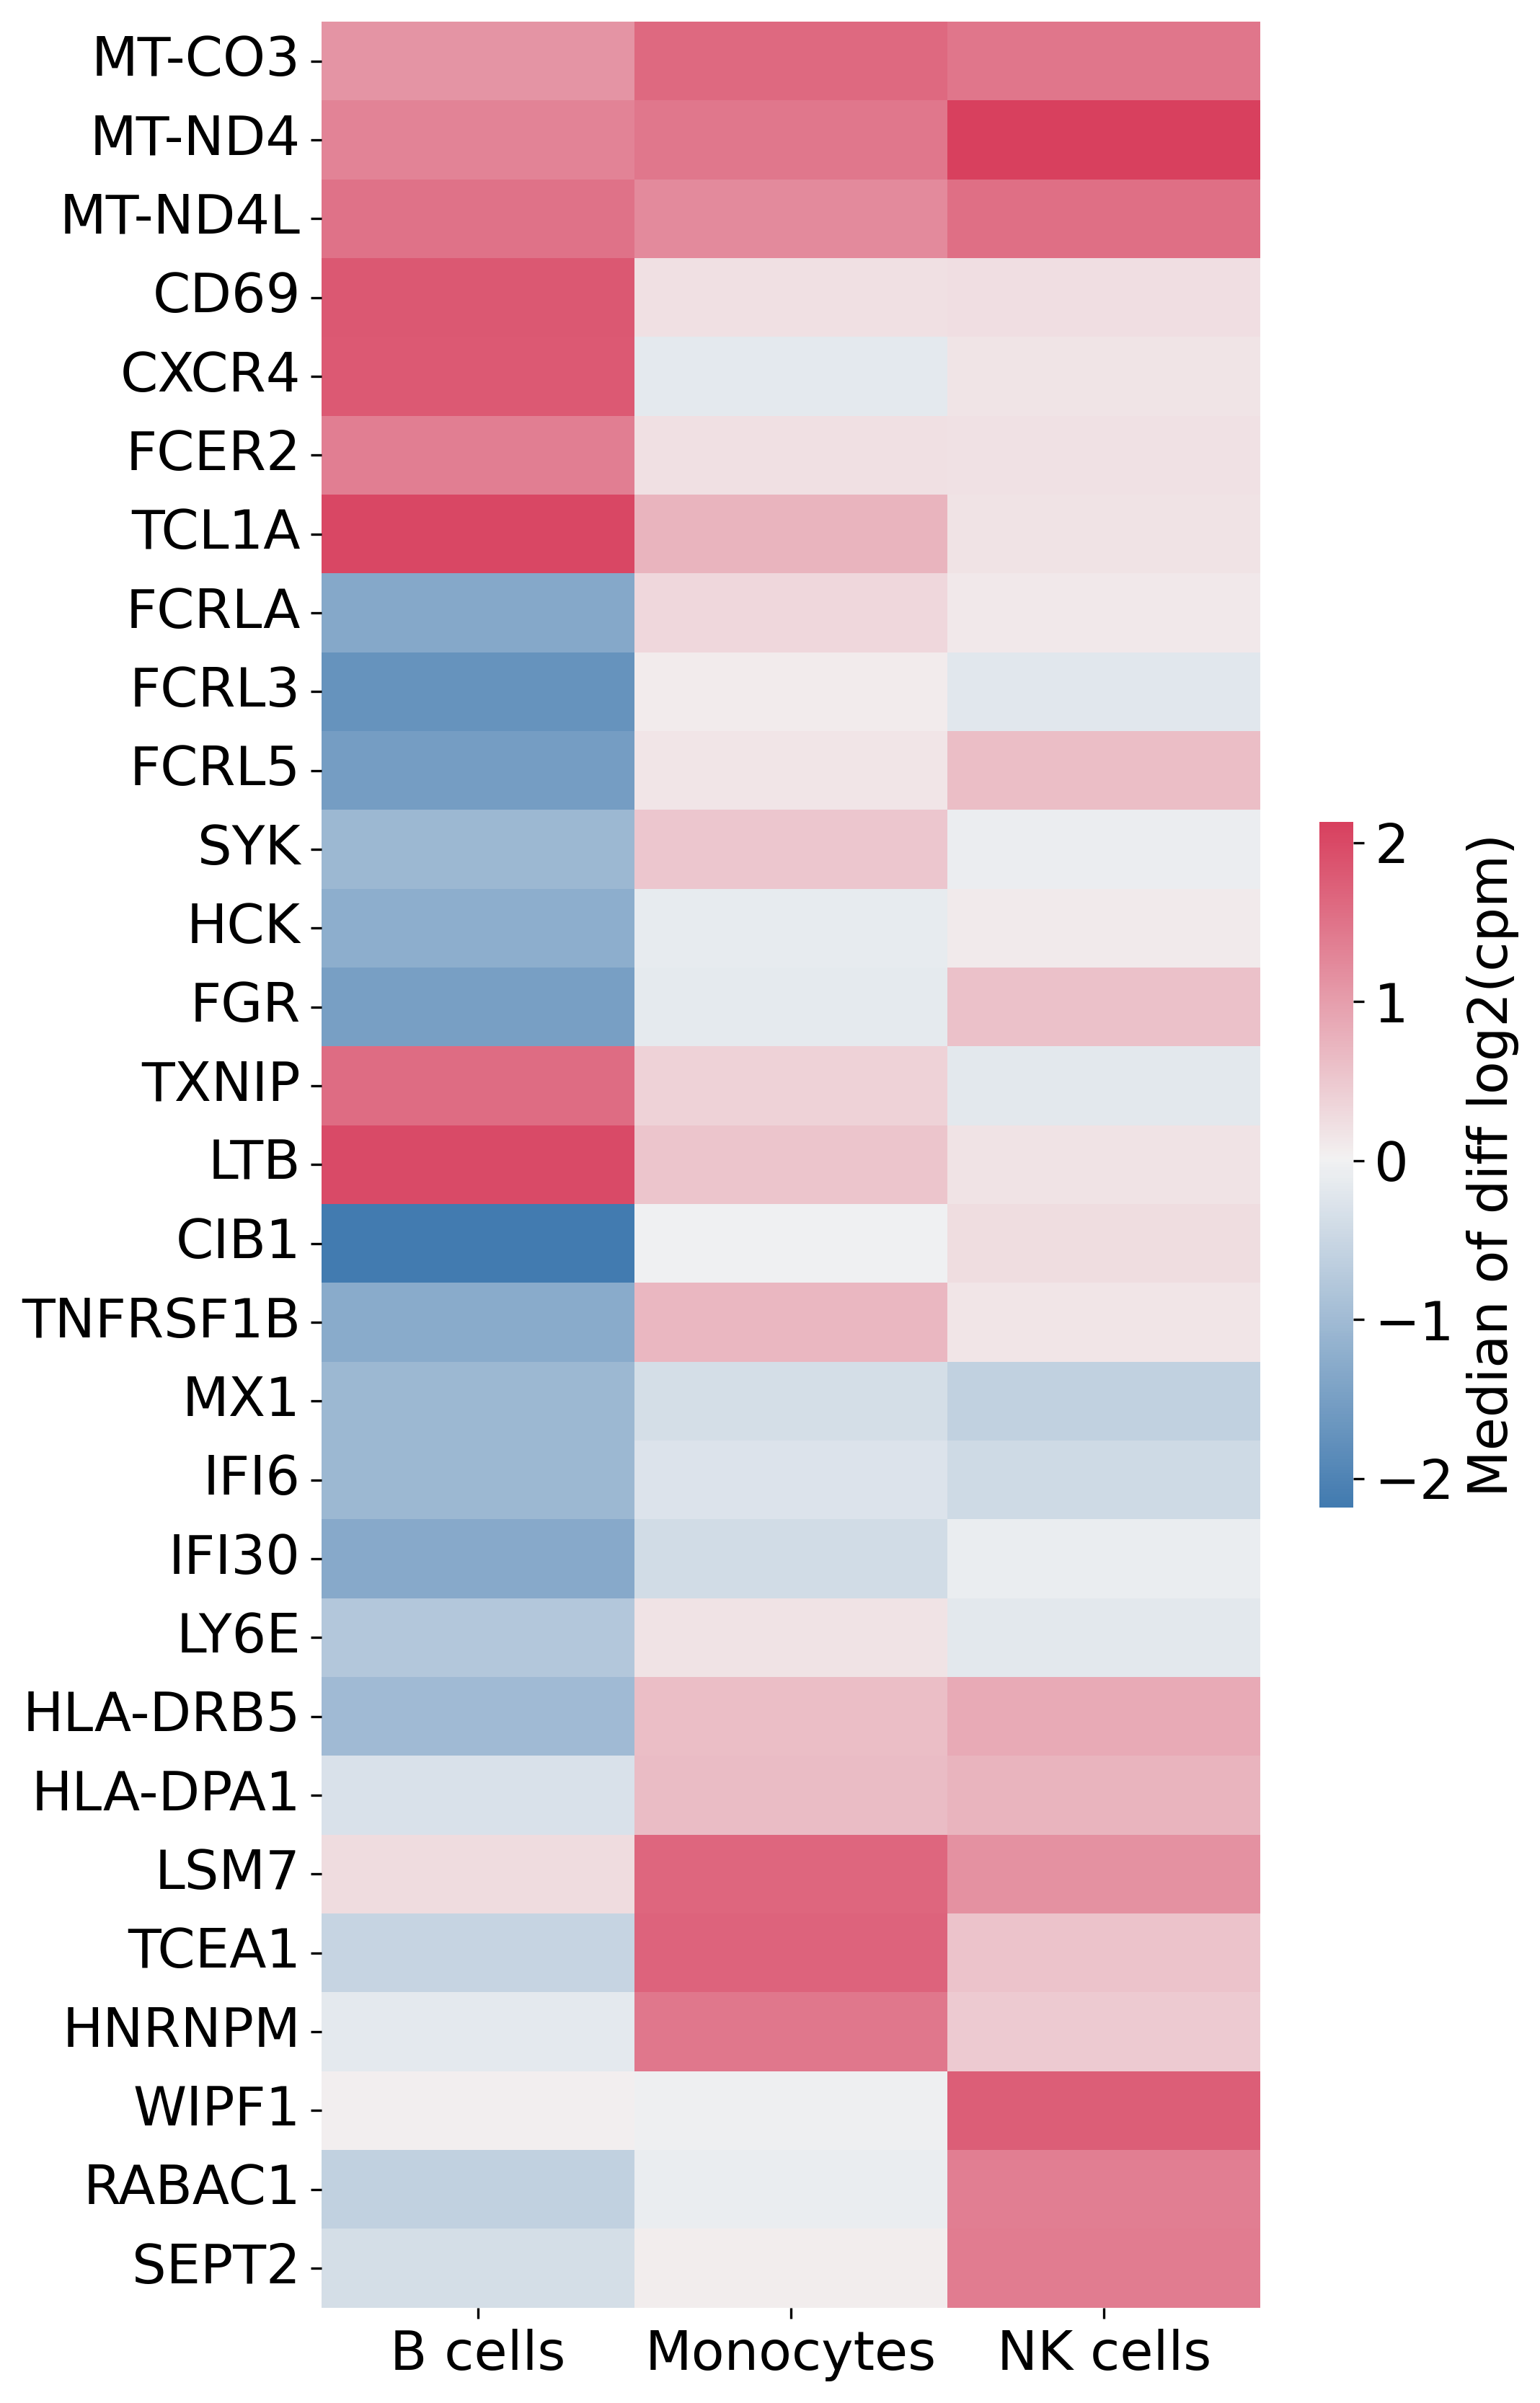

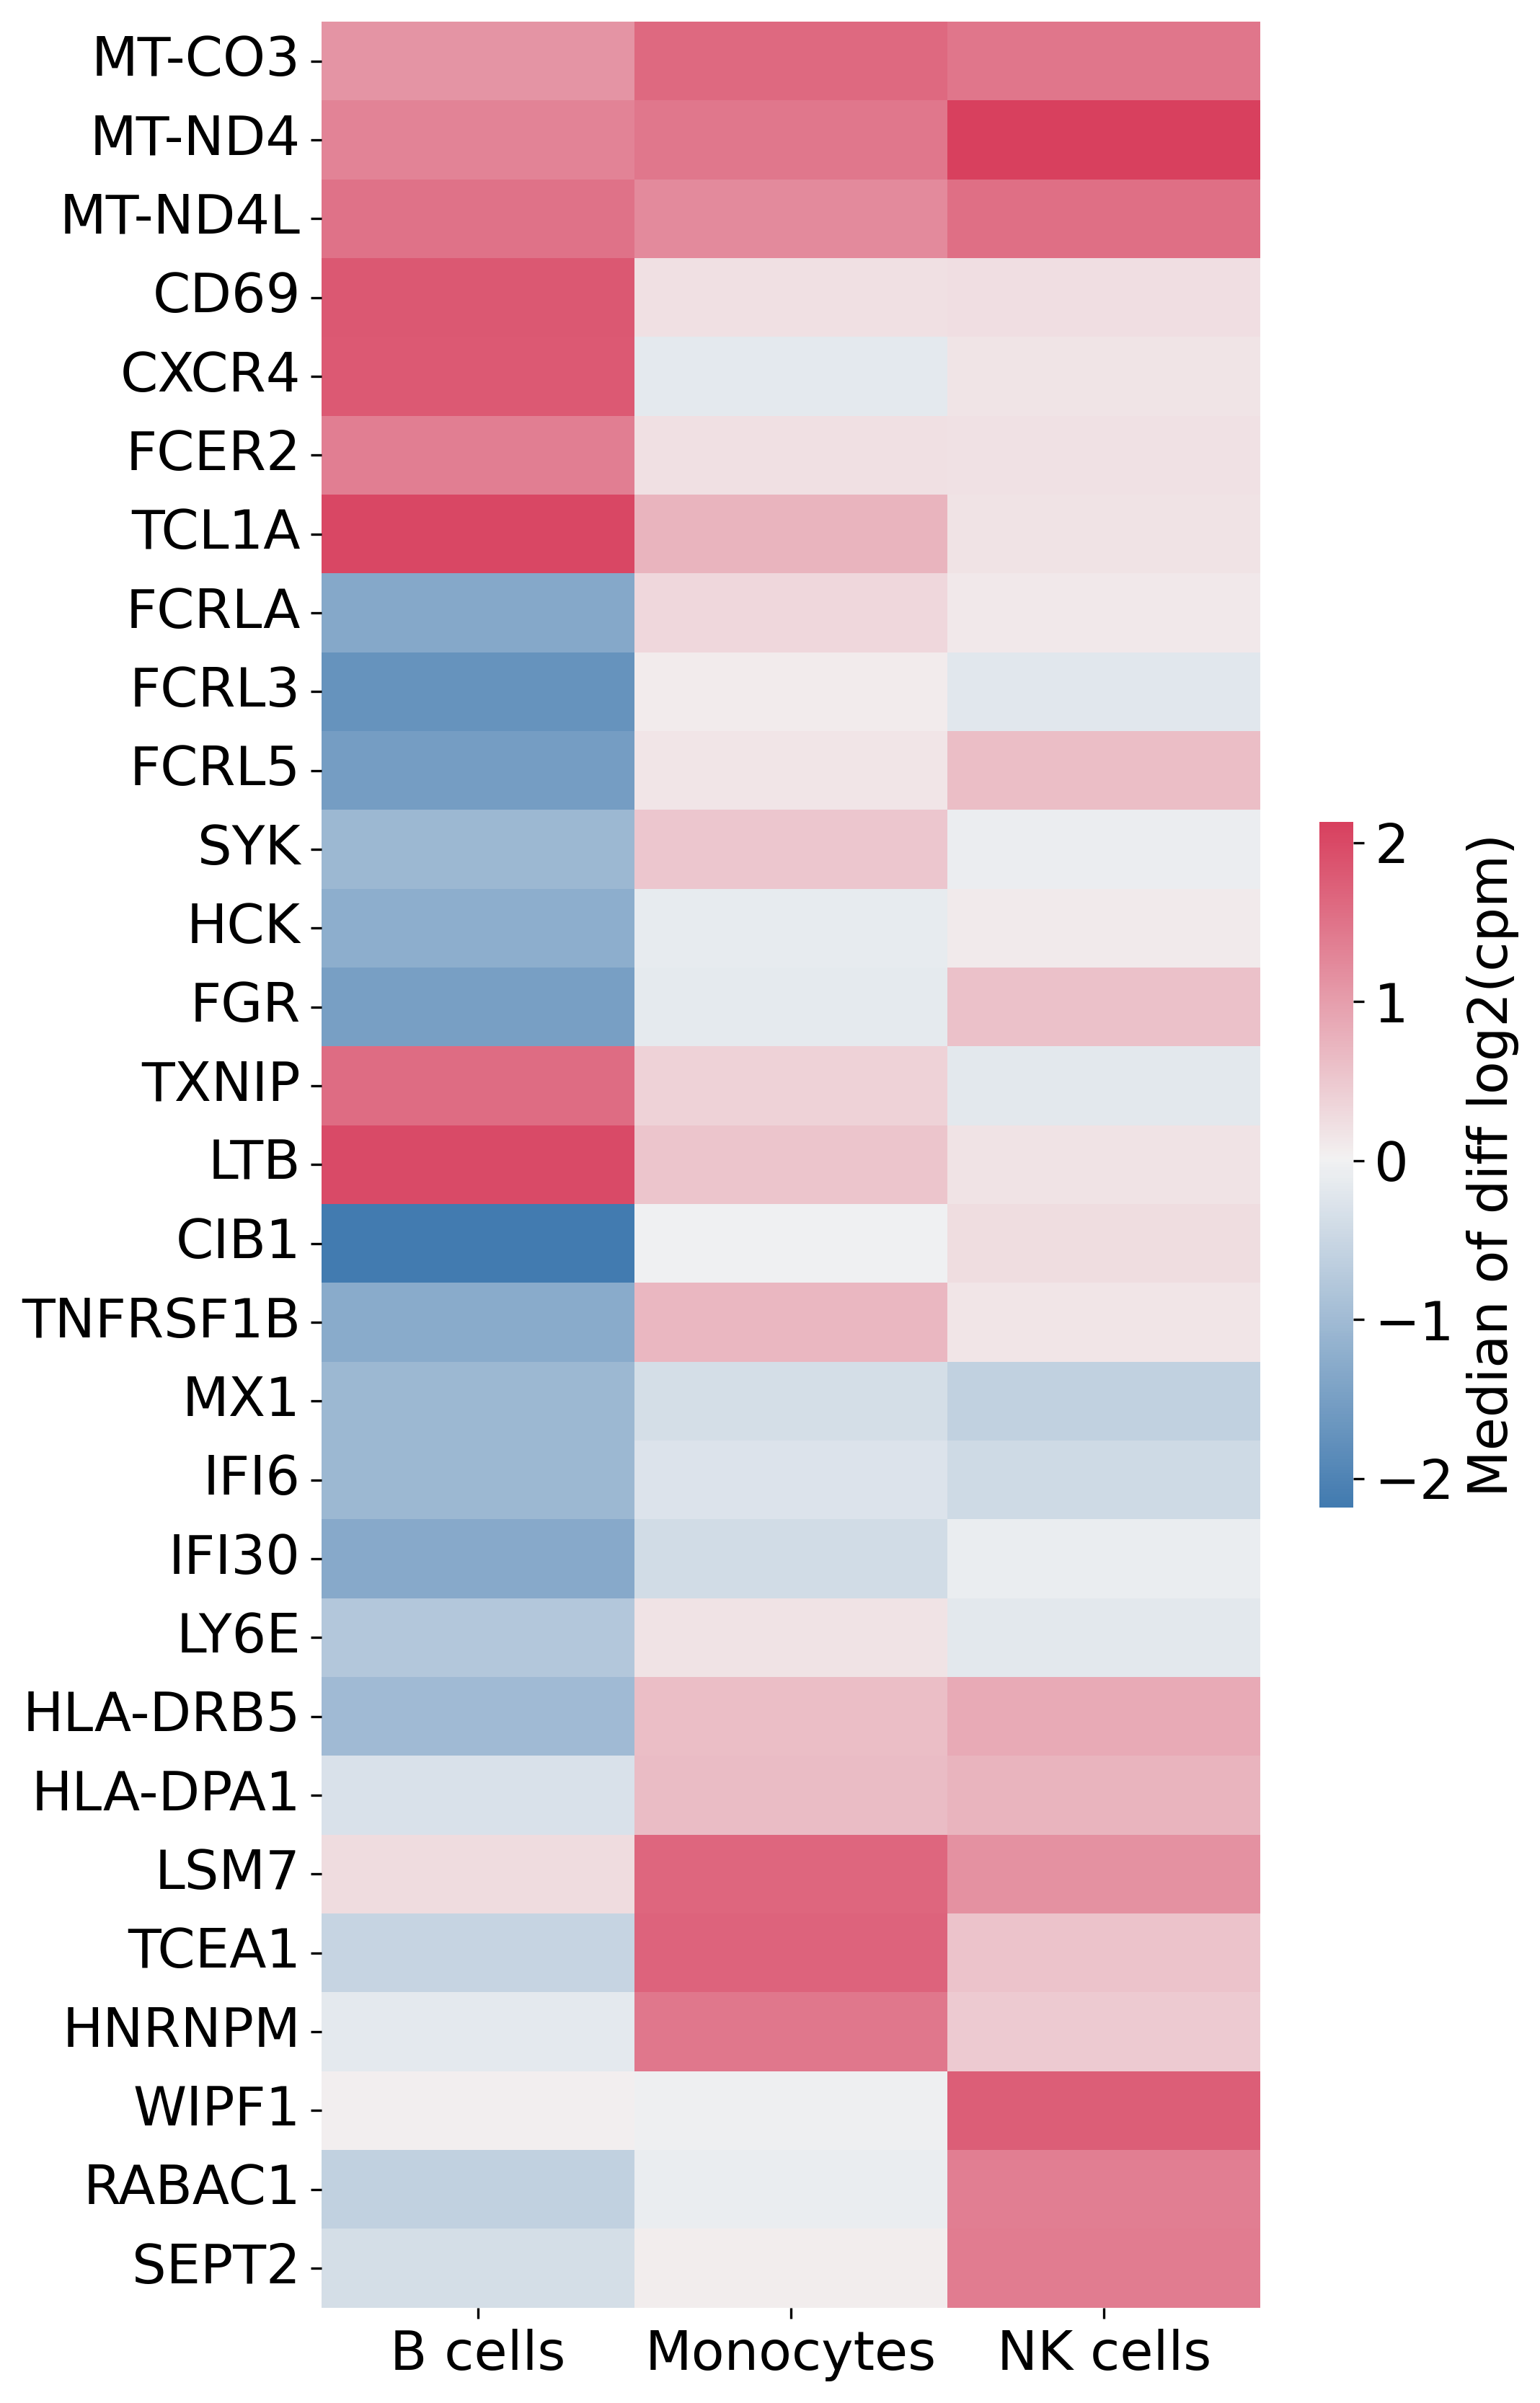

In [21]:
dic_list = [dic_b_1, dic_m_1, dic_n_1]
n_cutoff_list = [df_b, df_m, df_n]

df_list = bar_plot_other_celltype(dic_list, genelist_heatmap)

heatmap_df = pd.DataFrame(columns=['B cells', 'Monocytes', 'NK cells'], index=df_list[0].index)
for col, df in zip(['B cells', 'Monocytes', 'NK cells'], df_list):
    heatmap_df[col] = df.median(axis=1)

heatmap_virus(heatmap_df, save_figures, '.pdf')
heatmap_virus(heatmap_df, save_figures, '.png')

# In adults and children

/tmp/ipykernel_52513/3764270047.py:161: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  palette = [cmap(norm(x)) for x in np.clip(data.median(axis=1), -2.5, 2.5)]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
/tmp/ipykernel_52513/3764270047.py:161: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_

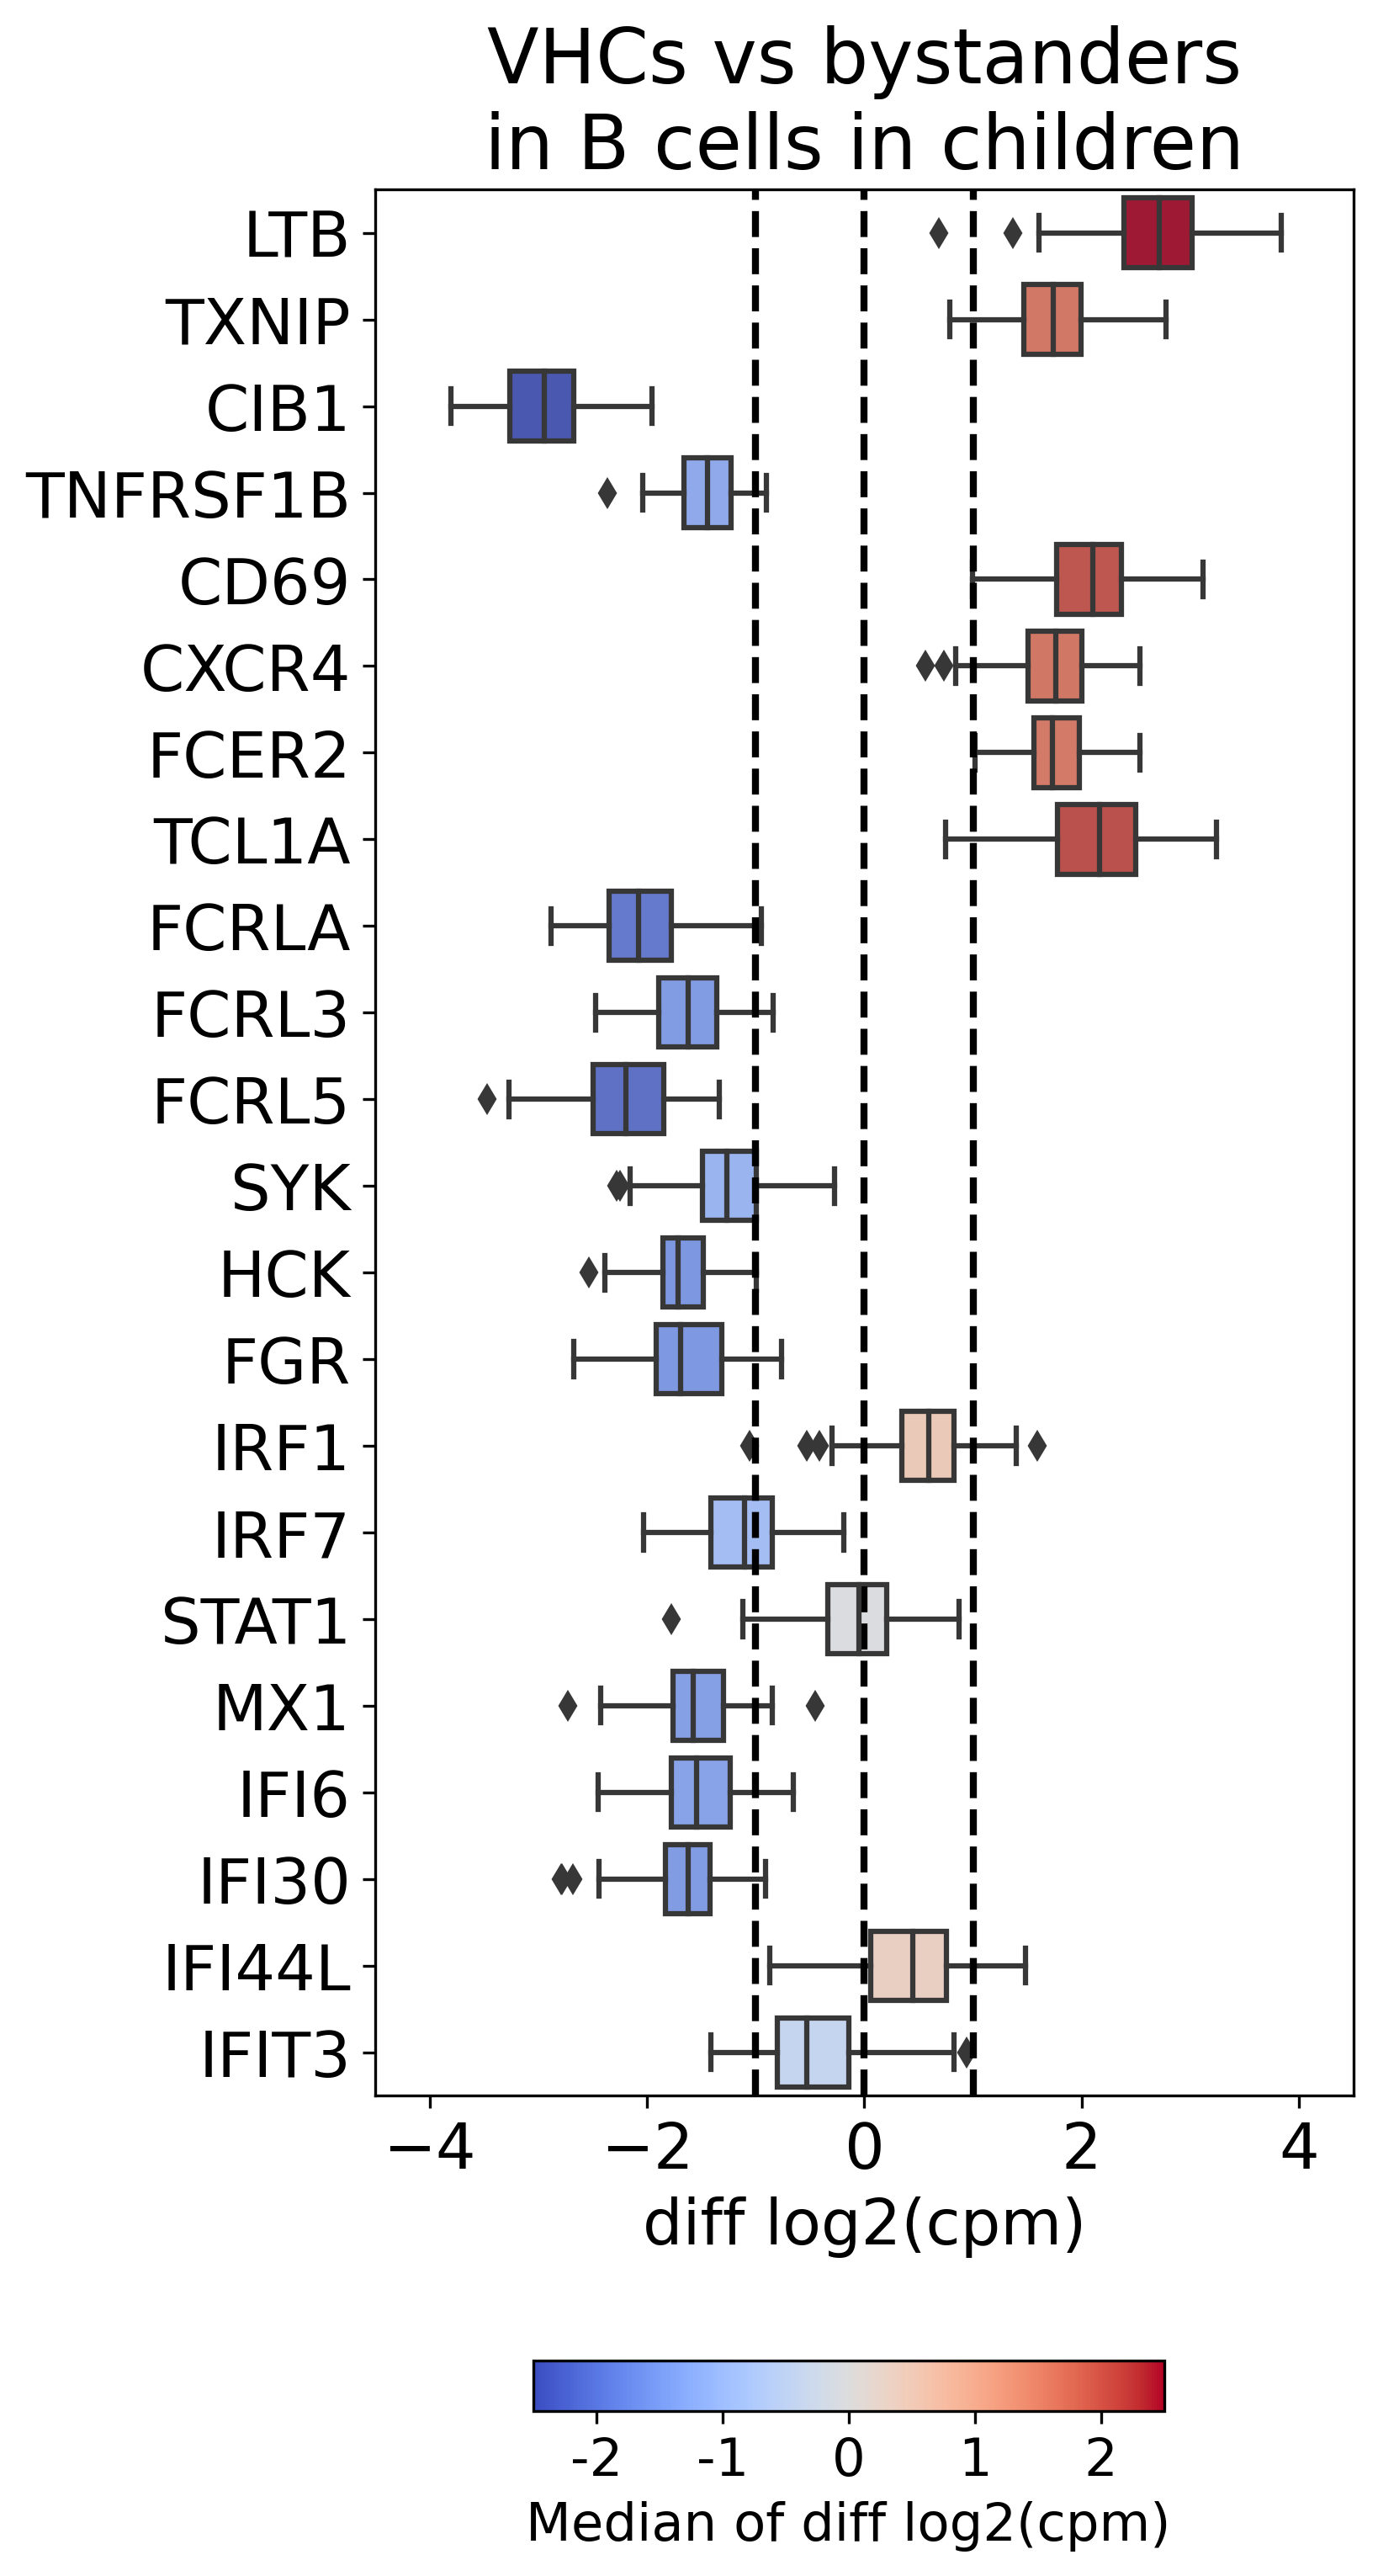

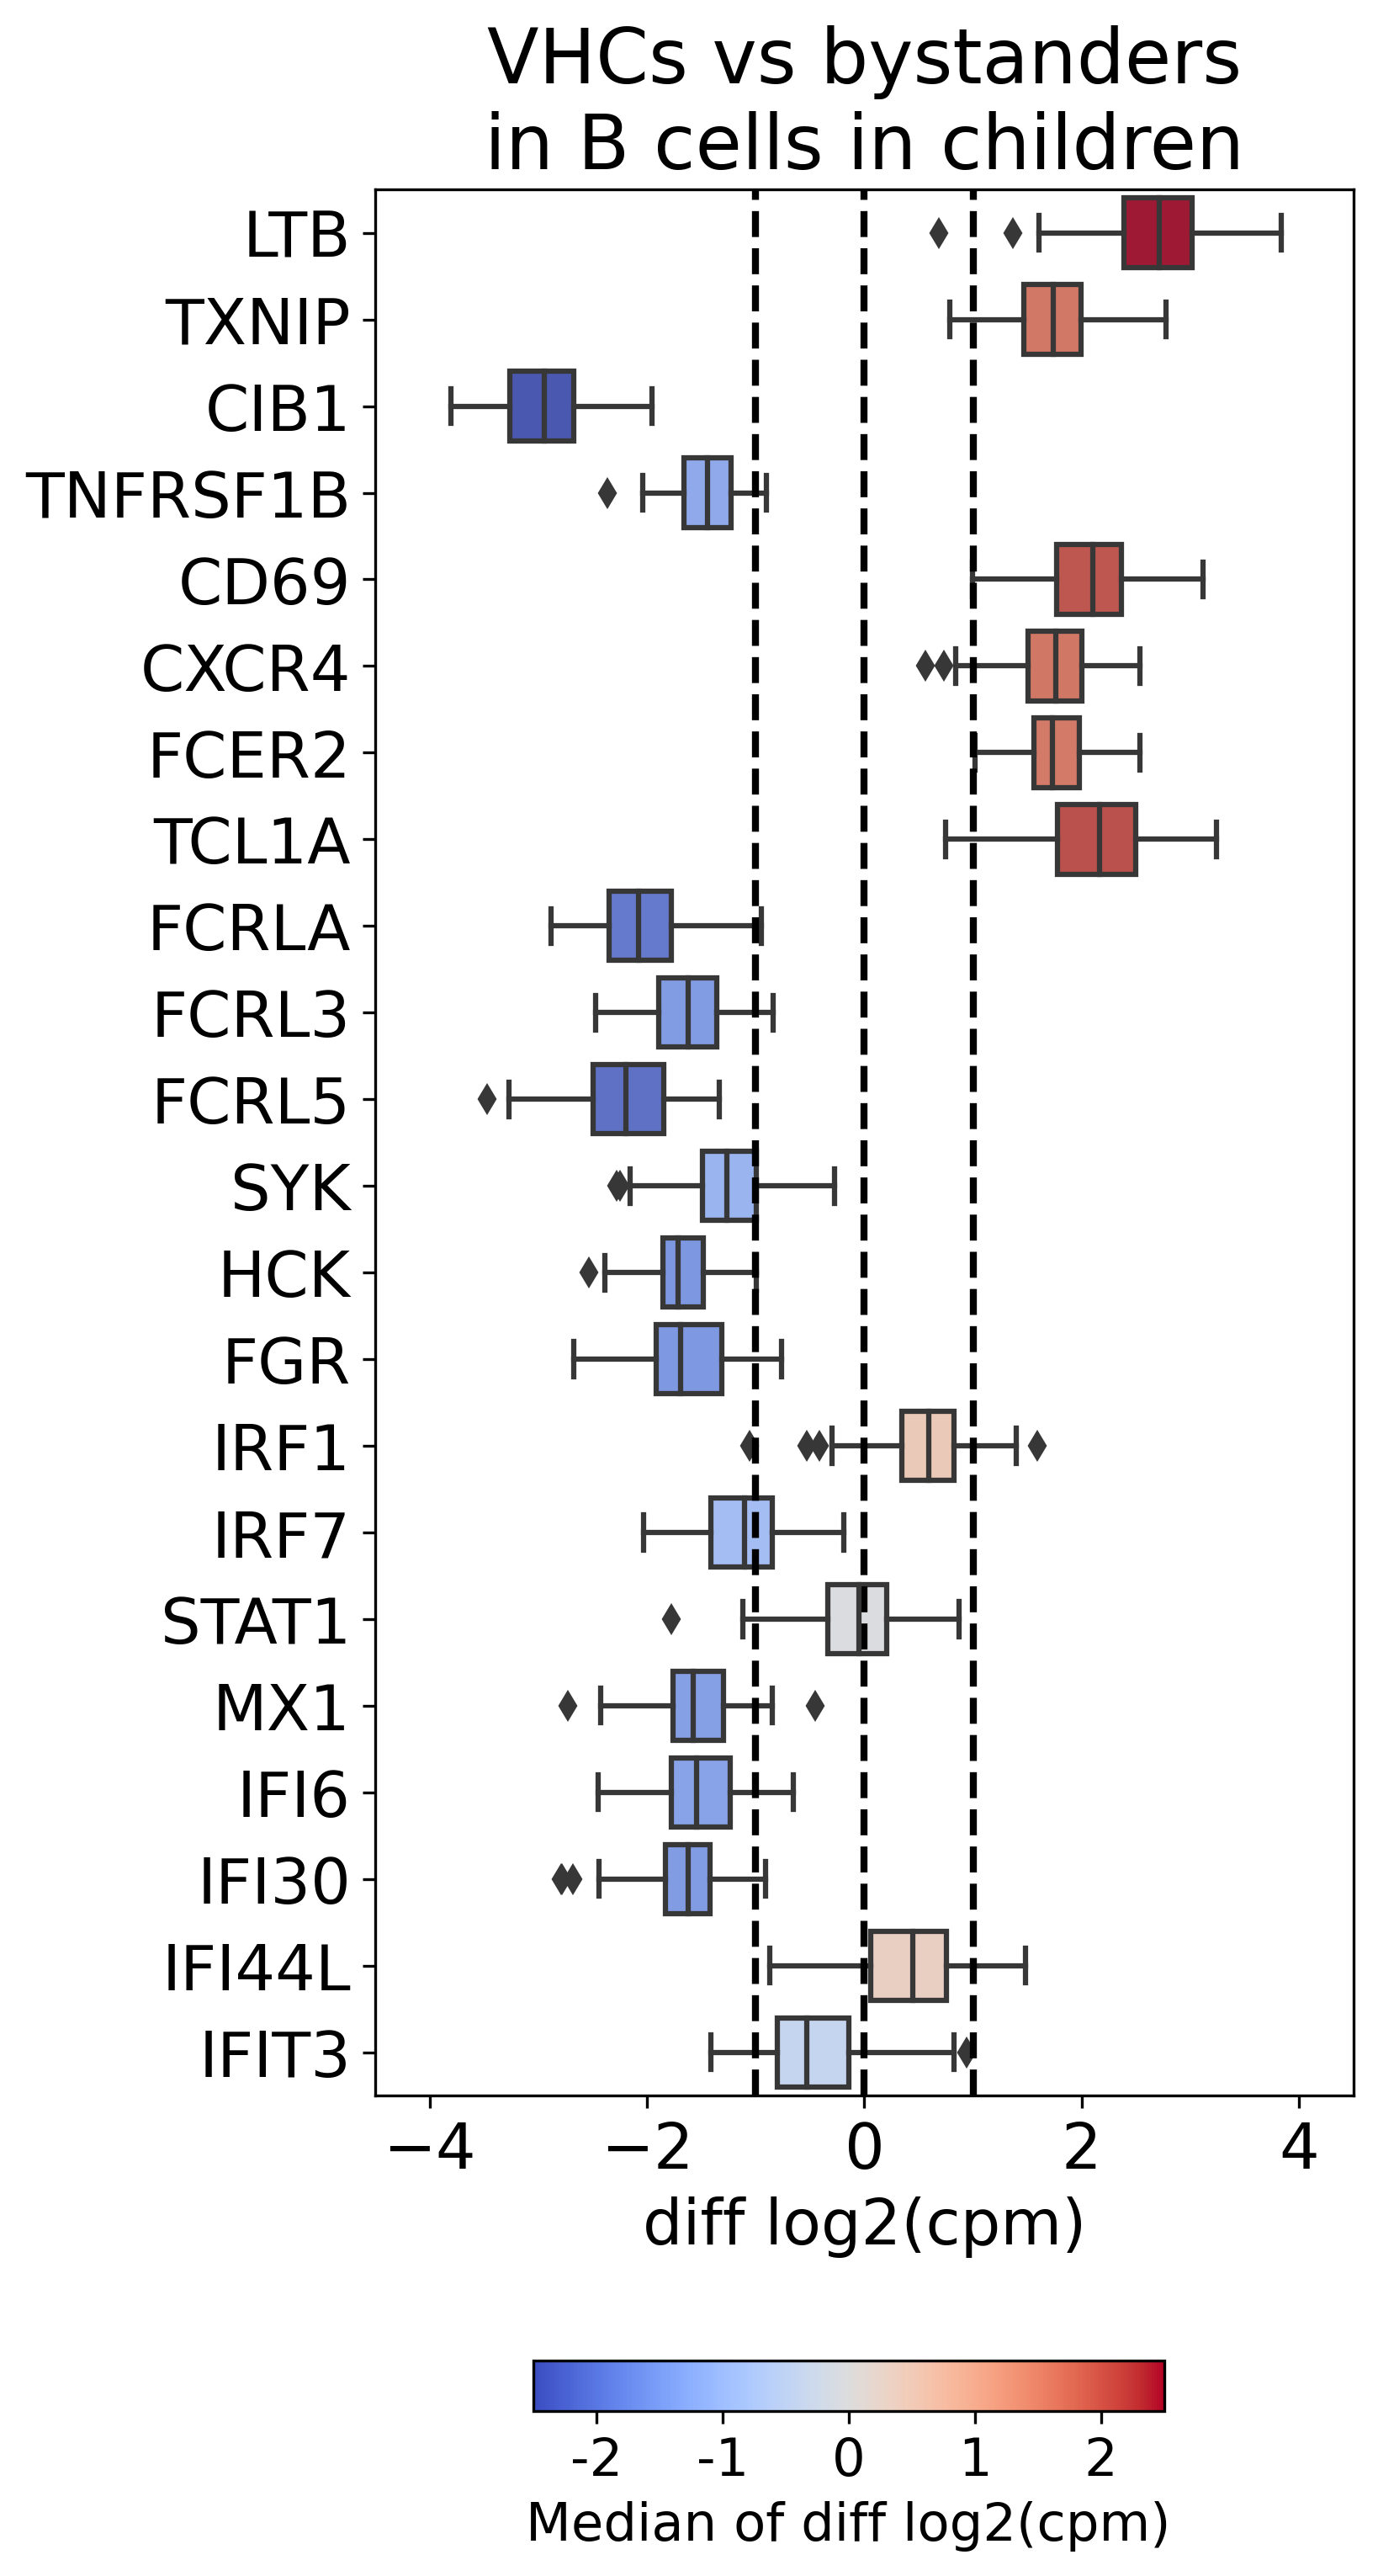

In [12]:
#for Figure 2E

genelist = [
            'LTB', 'TXNIP', 'CIB1', 'TNFRSF1B',
            'CD69', 
            'CXCR4', 'FCER2', 'TCL1A',#'CCR7', 
            'FCRLA','FCRL3', 'FCRL5', 'SYK', 'HCK', 'FGR',  
            'IRF1', 'IRF7', 'STAT1',
            'MX1', 'IFI6', 'IFI30', 'IFI44L', 'IFIT3', ]

#try bootstrap
dic_1, dic_2, df_boot = bootstrap_2(adata_kid_DWS_B[:, genelist], 100, 2)

df_temp = dicmerge(dic_1, genelist)
# df_temp = df_temp.sort_values(by = 'median', ascending = False)

pairwise_barplot(df_temp, save_figures, 'VHCs vs bystanders\nin B cells in children', 
                 'pdf', figure_size = (5, 10))
pairwise_barplot(df_temp, save_figures, 'VHCs vs bystanders\nin B cells in children', 
                 'png', figure_size = (5, 10))

In [13]:
#for Figure 2E (original Figure 2C), adult

#load data
adata_adult = subsetdata(adata, platform ='plate')
adata_adult = normalizedata(adata_adult)
adata_adult = removegenes(adata_adult)

In [19]:
#subsetting to adult B cells and preprocessing
adata_adult_B = pre_processing_1(adata_adult, 'B_cells')

genelist_a = ['LTB_1', 'TXNIP', 'CIB1', 'TNFRSF1B',
            'CD69', 
            'CXCR4', 'FCER2', 'TCL1A',#'CCR7', 
            'FCRLA','FCRL3', 'FCRL5', 'SYK', 'HCK', 'FGR',  
            'IRF1', 'IRF7_1', 'STAT1',
            'MX1', 'IFI6', 'IFI30', 'IFI44L', 'IFIT3',]# 'LTB1', 'IRF7'

#try bootstrap
dic_1_a, dic_2_a, df_boot_a = bootstrap(adata_adult_B[:, genelist_a], 100, 2)

/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:233: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['DENV_reads_cpm'] = (temp.obs['DENV_reads'] / temp.obs['n_counts']) * 1e6


/tmp/ipykernel_52513/3764270047.py:161: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  palette = [cmap(norm(x)) for x in np.clip(data.median(axis=1), -2.5, 2.5)]
/tmp/ipykernel_52513/3764270047.py:161: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  palette = [cmap(norm(x)) for x in np.clip(data.median(axis=1), -2.5, 2.5)]


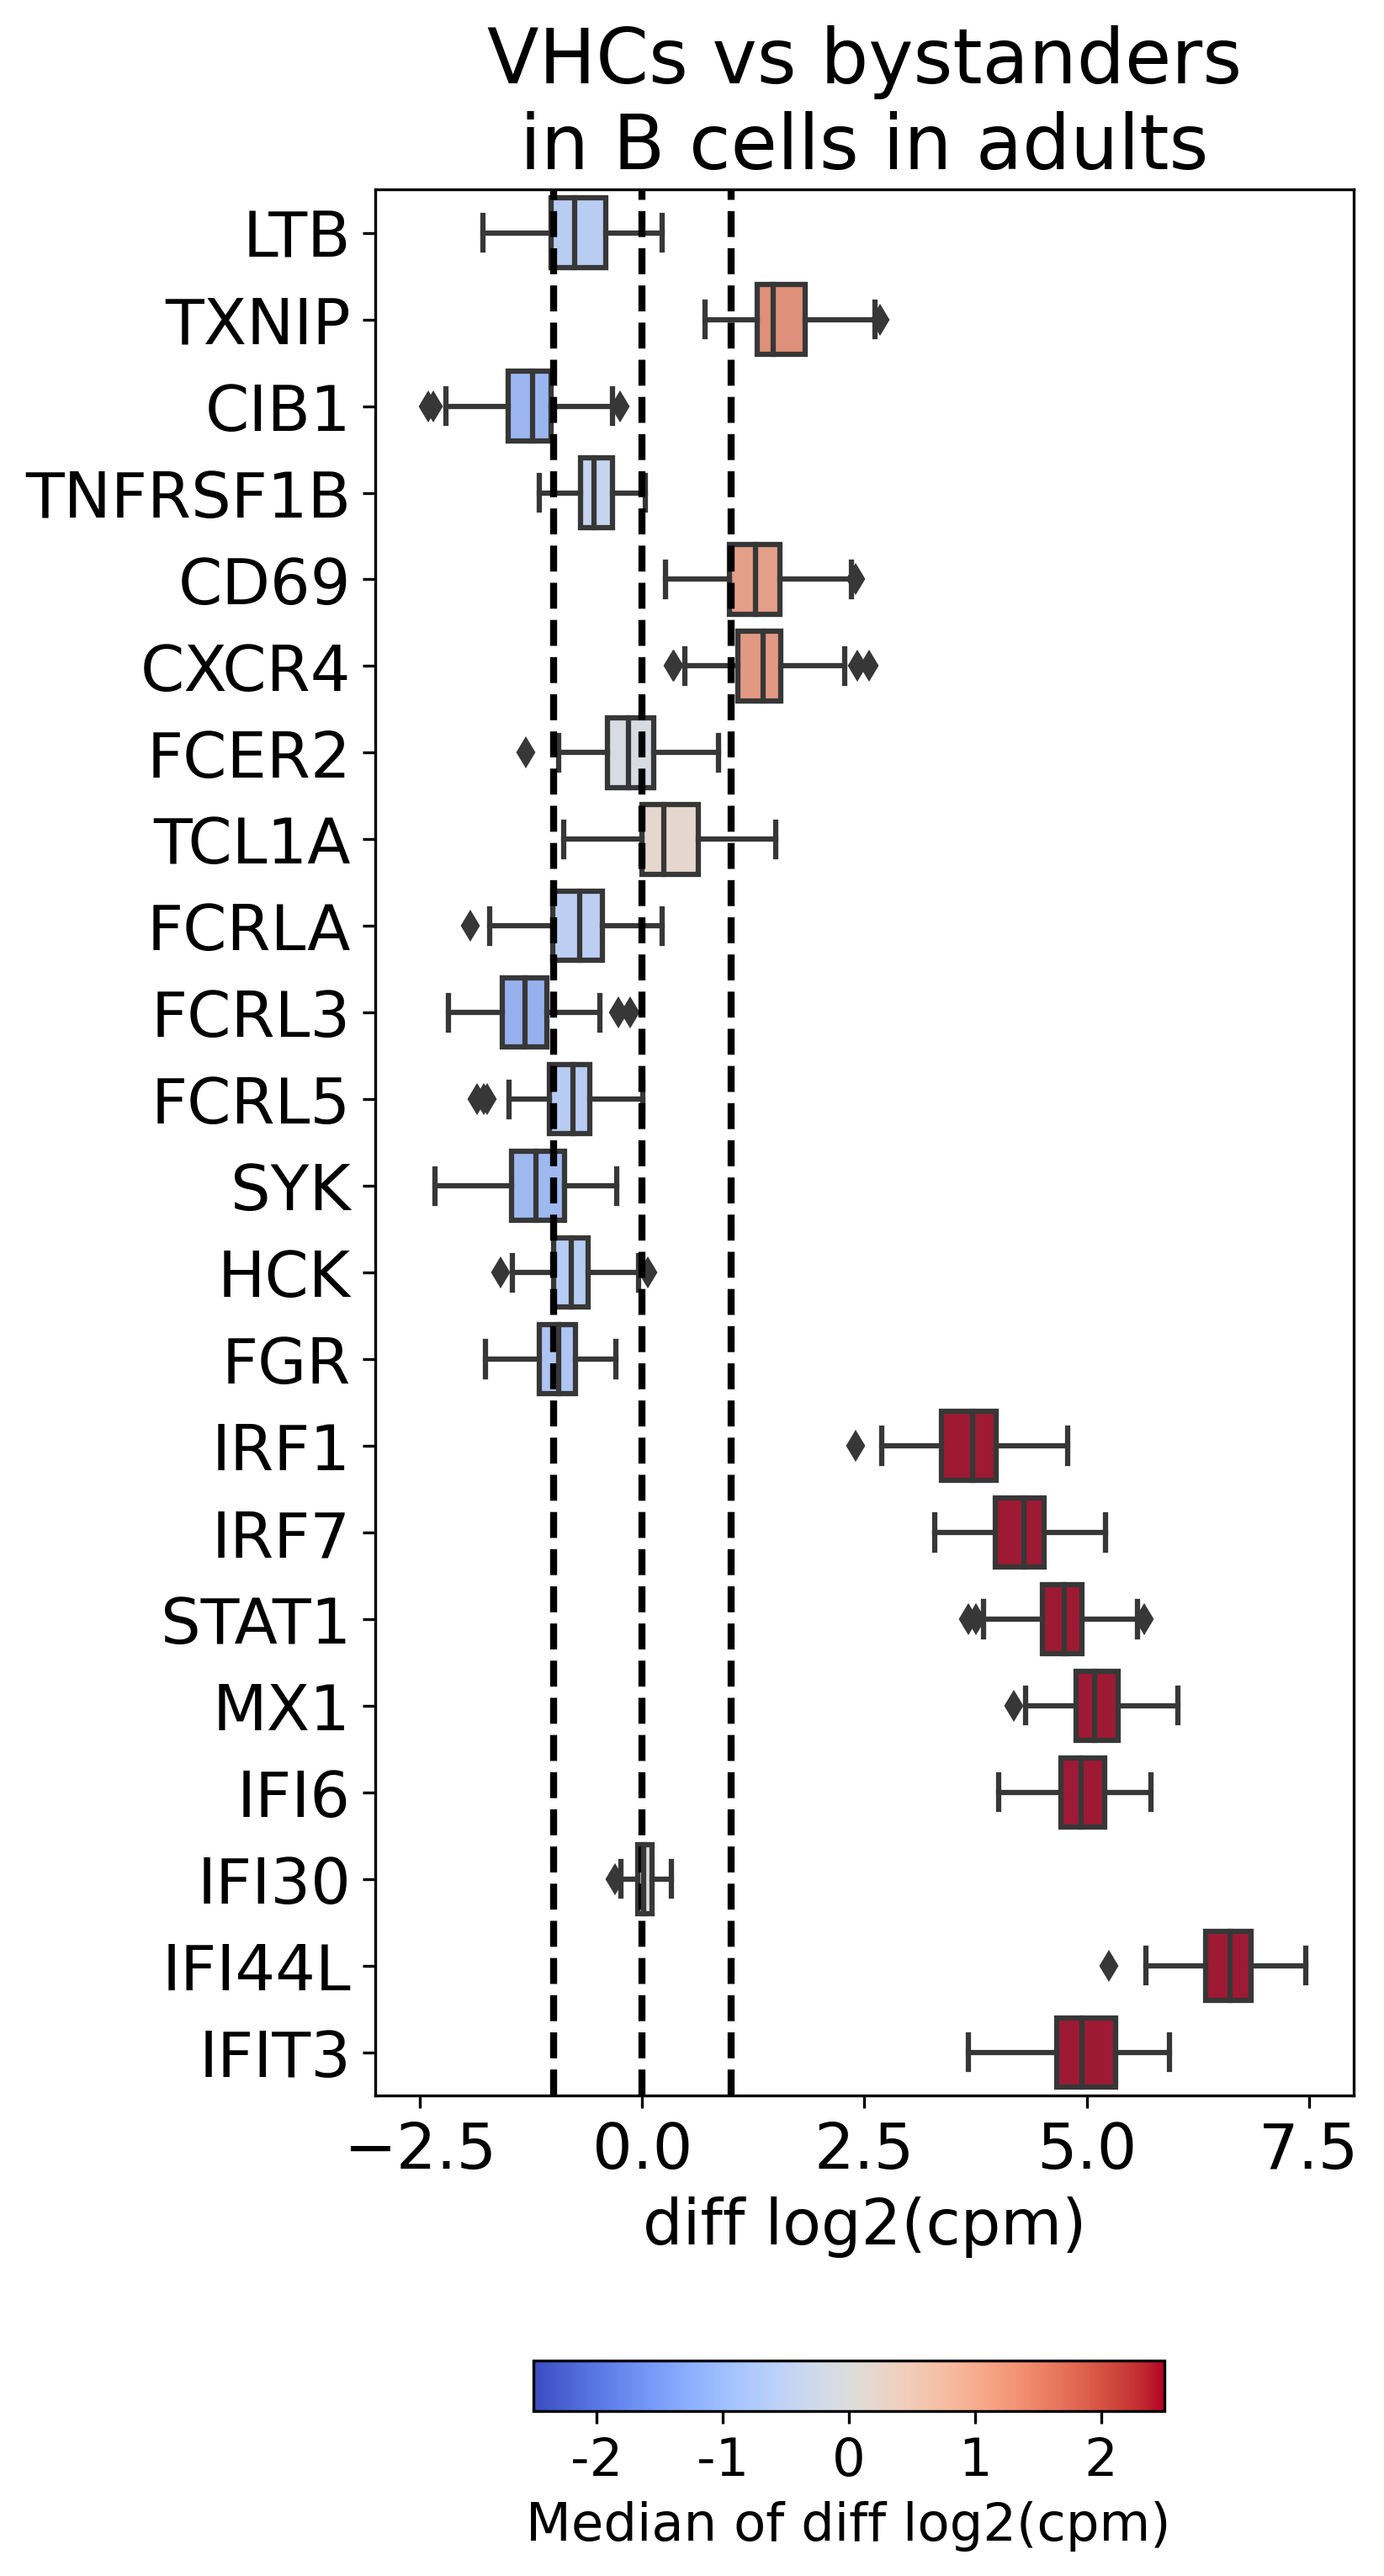

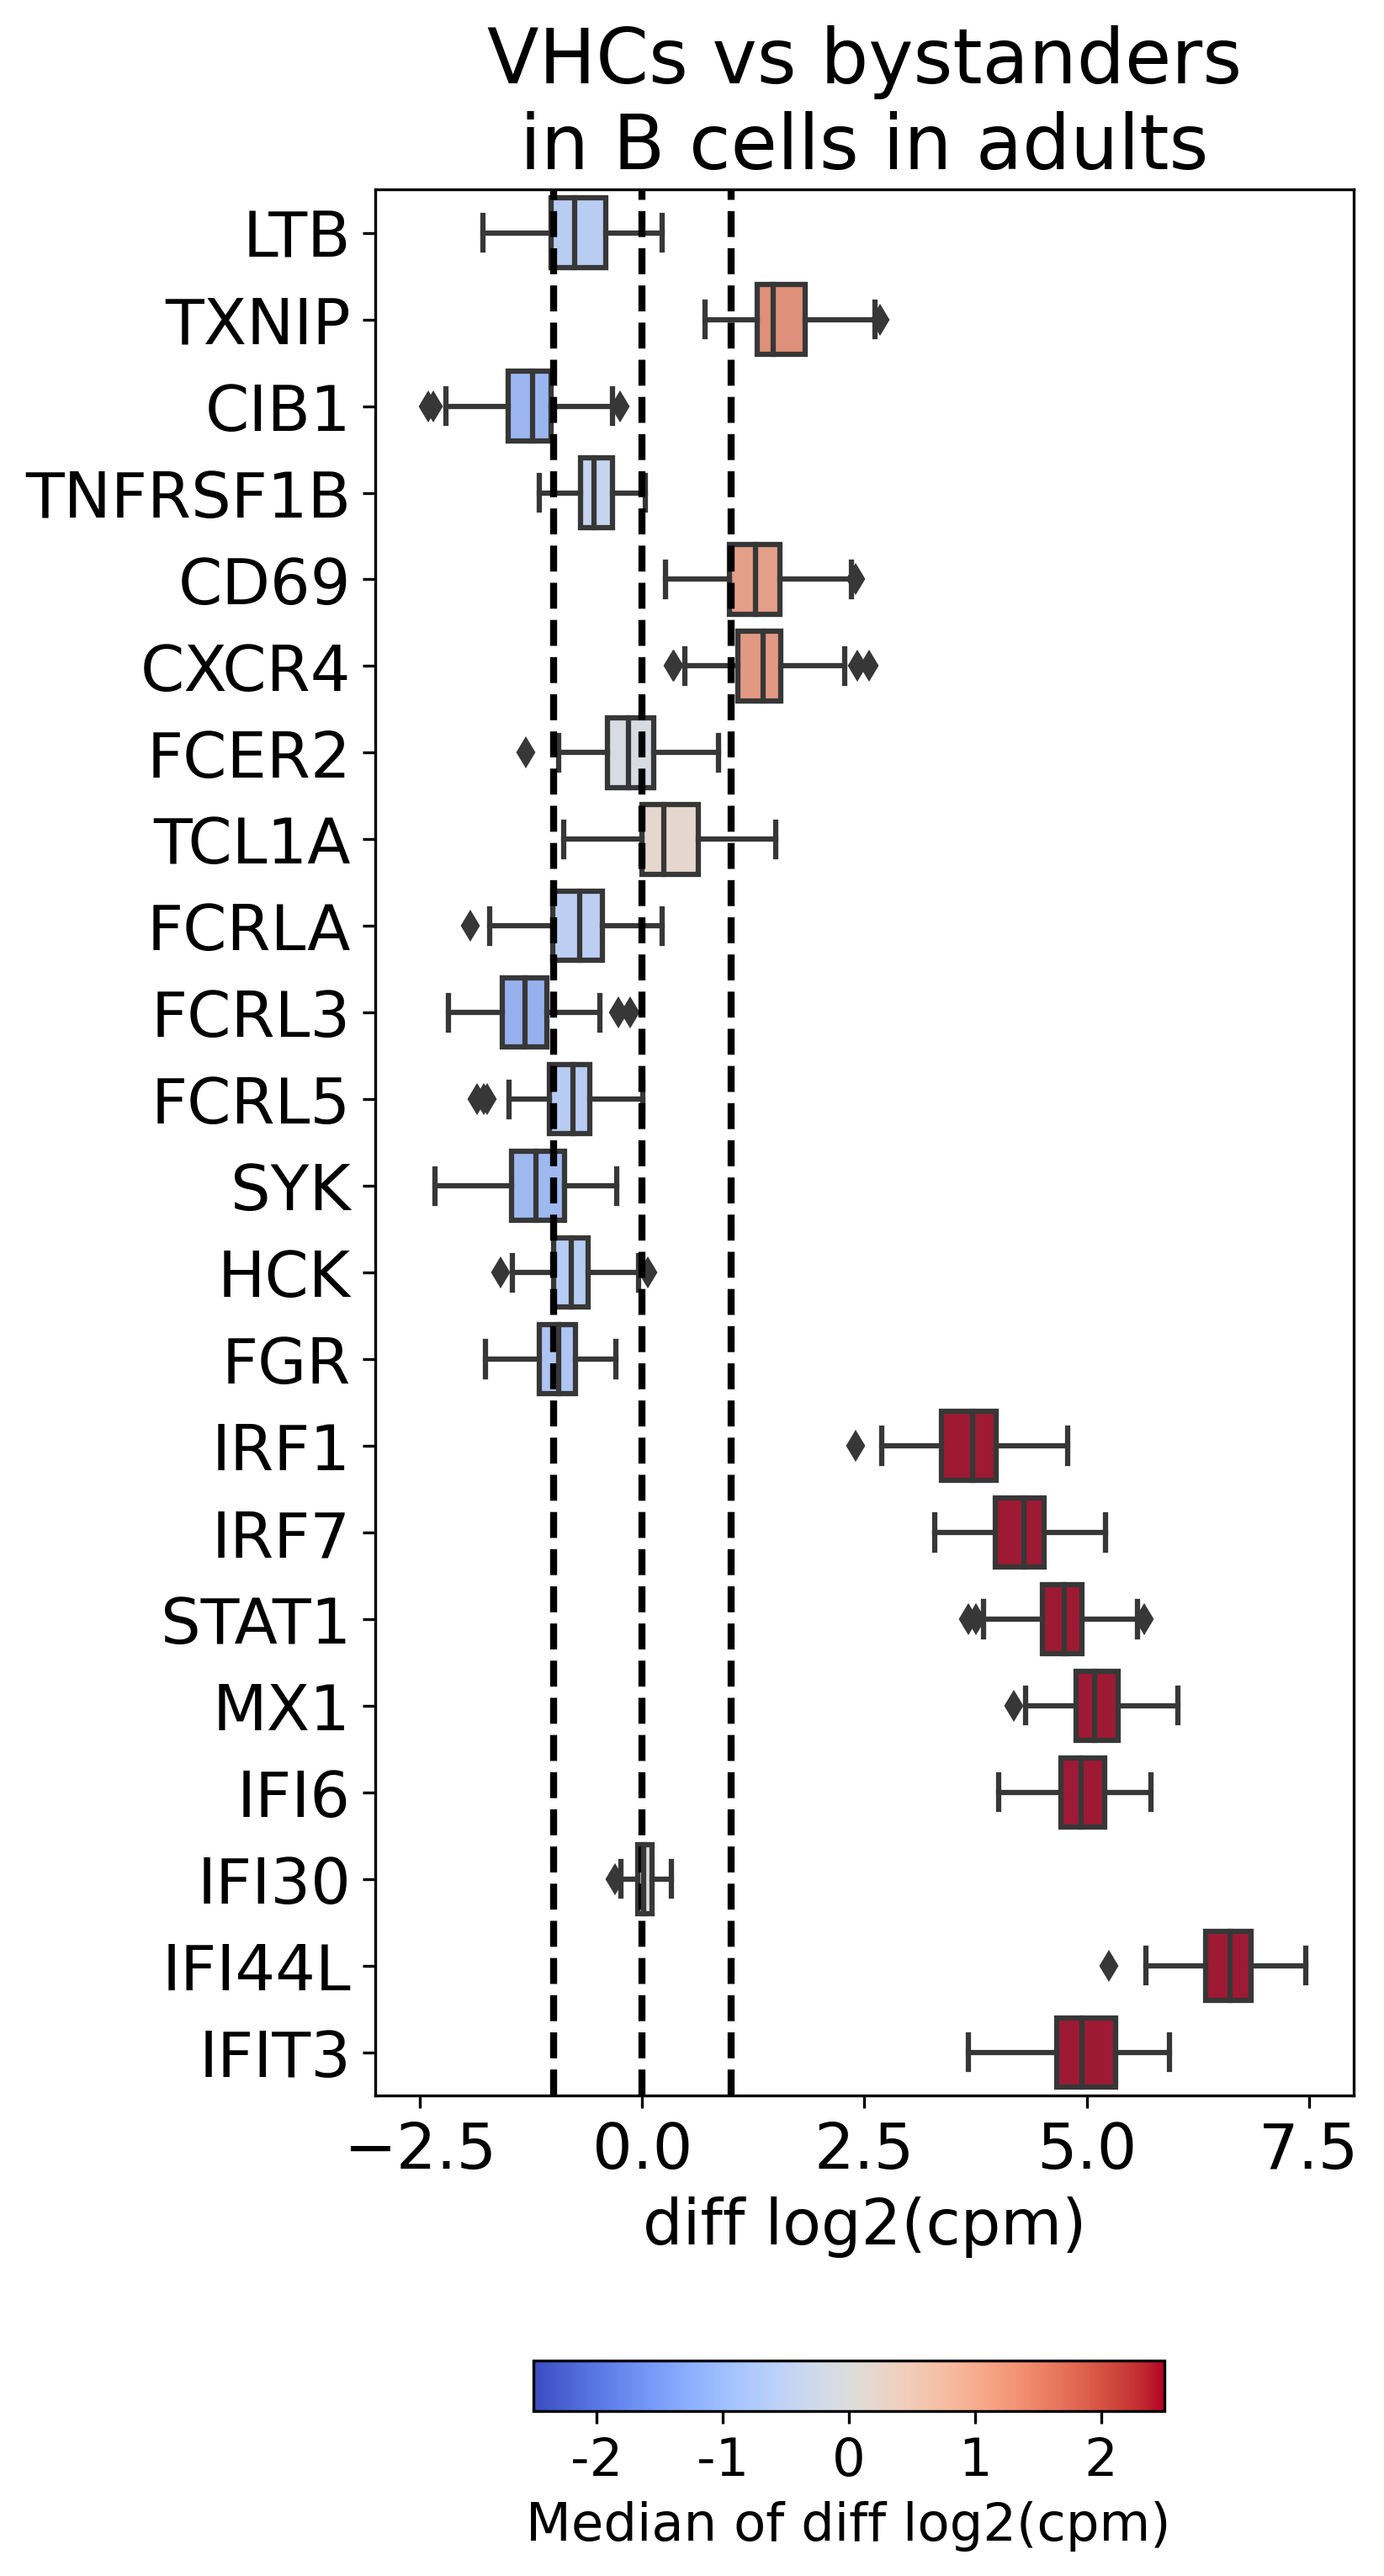

In [20]:
#plotting 

df_temp_a = dicmerge(dic_1_a, genelist_a)
df_temp_a.index = [x.split('_')[0] for x in df_temp_a.index]

pairwise_barplot(df_temp_a, save_figures, 'VHCs vs bystanders\nin B cells in adults', 
                 'pdf', figure_size = (5, 10), xlim_down=-3, xlim_up=8)
pairwise_barplot(df_temp_a, save_figures, 'VHCs vs bystanders\nin B cells in adults', 
                 'png', figure_size = (5, 10), xlim_down=-3, xlim_up=8)